In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('merged_data.csv')
geoloc_df = pd.read_csv('archive/olist_geolocation_dataset.csv')

In [12]:
df['delay'] = (pd.to_datetime(df["order_estimated_delivery_date"]) - pd.to_datetime(df["order_delivered_customer_date"])).dt.days

In [13]:
geo_aggregated = geoloc_df.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

In [14]:
df = df.merge(geo_aggregated, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'juruti'),
  Text(1, 0, 'portalegre'),
  Text(2, 0, 'apuarema'),
  Text(3, 0, "alvorada d'oeste"),
  Text(4, 0, 'japoata'),
  Text(5, 0, 'xexeu'),
  Text(6, 0, 'acari'),
  Text(7, 0, 'senador guiomard'),
  Text(8, 0, 'boa vista das missoes'),
  Text(9, 0, 'humaita')])

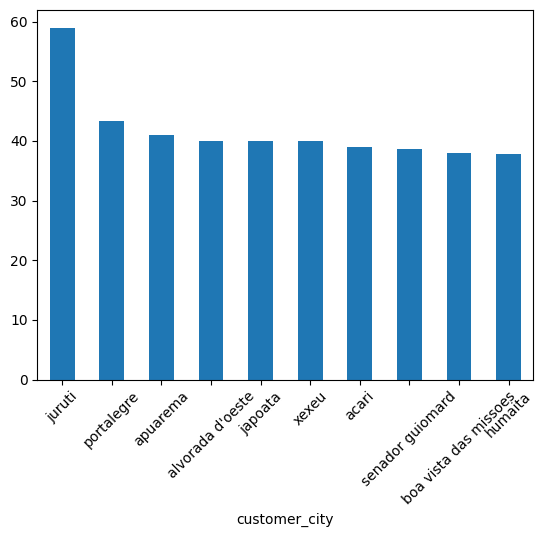

In [15]:
df.groupby("customer_city")["delay"].mean().sort_values(ascending=False)[:10].plot(kind="bar")
plt.xticks(rotation=45)

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

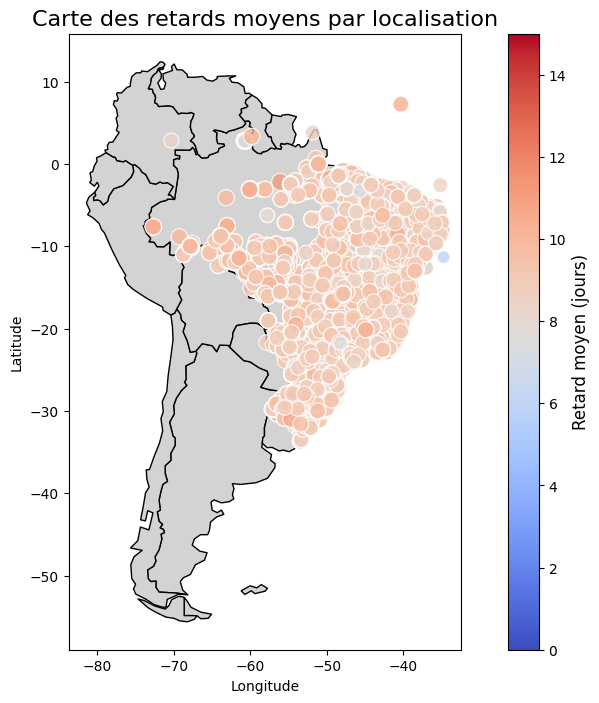

In [17]:
data = df.copy()

filtered_data = data[
    (data['geolocation_lat'] > -60) & (data['geolocation_lat'] < 15) &
    (data['geolocation_lng'] > -80) & (data['geolocation_lng'] < -30) 
]


world = gpd.read_file('geopandas_maps/ne_110m_admin_0_countries.shp')


fig, ax = plt.subplots(figsize=(12, 8))
world[world['CONTINENT'] == 'South America'].plot(ax=ax, color='lightgrey', edgecolor='black')


sns.scatterplot(
    x='geolocation_lng', y='geolocation_lat', size='delay', sizes=(10, 200),
    hue='delay', palette="coolwarm", data=filtered_data, ax=ax, alpha=0.8,
    legend=False 
)


sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=15))  
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Retard moyen (jours)", fontsize=12)


ax.set_title("Carte des retards moyens par localisation", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [ ]:
import googlemaps
from sklearn.cluster import KMeans

# Initialiser l'API Google Maps
API_KEY = "YOUR_GOOGLE_MAPS_API_KEY"  # Remplacez par votre clé API
gmaps = googlemaps.Client(key="API_KEY")

# Étape 1 : Extraire les latitudes/longitudes et les retards
geo_data = filtered_data[['geolocation_lat', 'geolocation_lng', 'delay']].dropna()

# Étape 2 : Identifier les zones de retard élevé
top_delays = geo_data[geo_data['delay'] > geo_data['delay'].quantile(0.75)]

# Étape 3 : Clustering pour regrouper les clients (KMeans)
coords = top_delays[['geolocation_lat', 'geolocation_lng']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
top_delays['Cluster'] = kmeans.labels_

# Étape 4 : Calculer le centre des clusters
cluster_centers = kmeans.cluster_centers_
print("Propositions de centres des clusters :")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: Latitude {center[0]}, Longitude {center[1]}")

# Étape 5 : Utiliser Google Maps API pour valider un emplacement central
proposed_locations = []
for center in cluster_centers:
    lat, lng = center
    result = gmaps.reverse_geocode((lat, lng))
    proposed_locations.append(result[0]['formatted_address'])

# Étape 6 : Calculer les distances depuis São Paulo
sp_location = (-23.5505, -46.6333)  # Dépôt actuel à São Paulo
distances = [
    gmaps.distance_matrix(sp_location, (lat, lng), mode="driving")['rows'][0]['elements'][0]['distance']['text']
    for lat, lng in cluster_centers
]

# Afficher les résultats
for i, (address, distance) in enumerate(zip(proposed_locations, distances)):
    print(f"Cluster {i}: {address} ({distance} depuis São Paulo)")

C:\Users\Audren\AppData\Local\Temp\ipykernel_10340\475383524.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_delays['Cluster'] = kmeans.labels_


Propositions de centres des clusters :
Cluster 0: Latitude -23.399999681249927, Longitude -46.68478265055967
Cluster 1: Latitude -11.247269835594603, Longitude -52.117451538432576
Cluster 2: Latitude -8.67504284372232, Longitude -38.48565940274684
Cluster 0: J828+23 Caieiras, State of São Paulo, Brazil (34.4 km depuis São Paulo)
Cluster 1: QV3M+32 Tatuibi - Espigão do Leste, São Félix do Araguaia - MT, Brazil (1,867 km depuis São Paulo)
Cluster 2: 8GF7+XP Floresta, PE, Brazil (2,358 km depuis São Paulo)


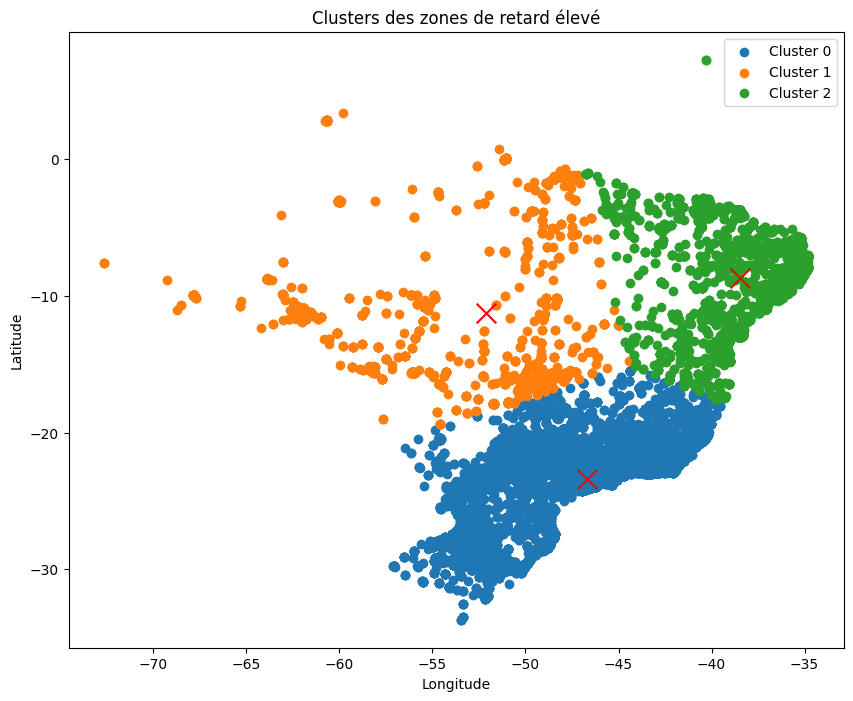

In [21]:
plt.figure(figsize=(10, 8))
for i in range(len(cluster_centers)):
    plt.scatter(top_delays[top_delays['Cluster'] == i]['geolocation_lng'],
                top_delays[top_delays['Cluster'] == i]['geolocation_lat'],
                label=f"Cluster {i}")

# Marquer les centres
for center in cluster_centers:
    plt.scatter(center[1], center[0], c='red', marker='x', s=200)

plt.title("Clusters des zones de retard élevé")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

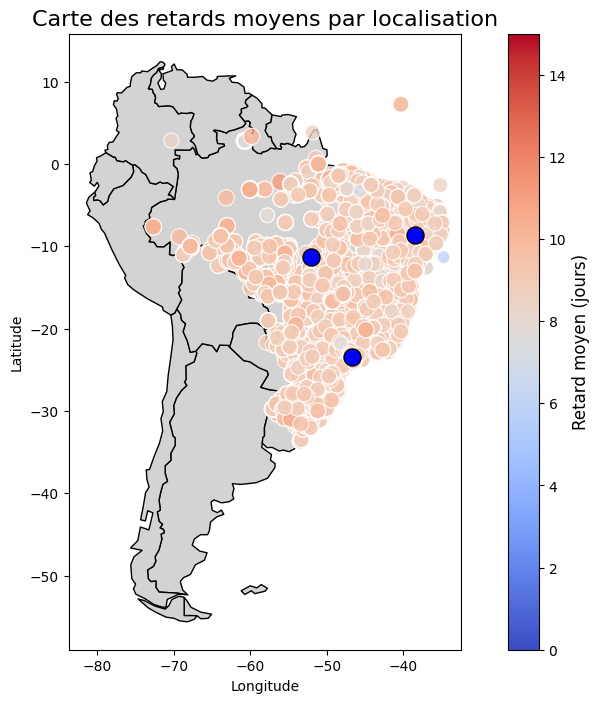

In [22]:
data = df.copy()

filtered_data = data[
    (data['geolocation_lat'] > -60) & (data['geolocation_lat'] < 15) &
    (data['geolocation_lng'] > -80) & (data['geolocation_lng'] < -30) 
]


world = gpd.read_file('geopandas_maps/ne_110m_admin_0_countries.shp')


fig, ax = plt.subplots(figsize=(12, 8))
world[world['CONTINENT'] == 'South America'].plot(ax=ax, color='lightgrey', edgecolor='black')

sao_paulo_coords = (-23.5505, -46.6333)
ax.scatter(
    sao_paulo_coords[1], sao_paulo_coords[0],
    c='red', s=200, label='Dépôt actuel (São Paulo)', marker='X', edgecolor='black'
)
sns.scatterplot(
    x='geolocation_lng', y='geolocation_lat', size='delay', sizes=(10, 200),
    hue='delay', palette="coolwarm", data=filtered_data, ax=ax, alpha=0.8,
    legend=False 
)
proposed_centers=[(-23.399999681249927,-46.68478265055967),
(-11.247269835594603,-52.117451538432576),
(-8.67504284372232, -38.48565940274684)]
for center in proposed_centers:
    ax.scatter(
        center[1], center[0],
        c='blue', s=150, label='Centre proposé', marker='o', edgecolor='black'
    )

sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=15))  
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Retard moyen (jours)", fontsize=12)


ax.set_title("Carte des retards moyens par localisation", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()